# IFEWS - Ethanol

Ethanol Optimization:
    The idea here is to extend the non-linear GRG analysis made for all Iowa to the sum of each county.

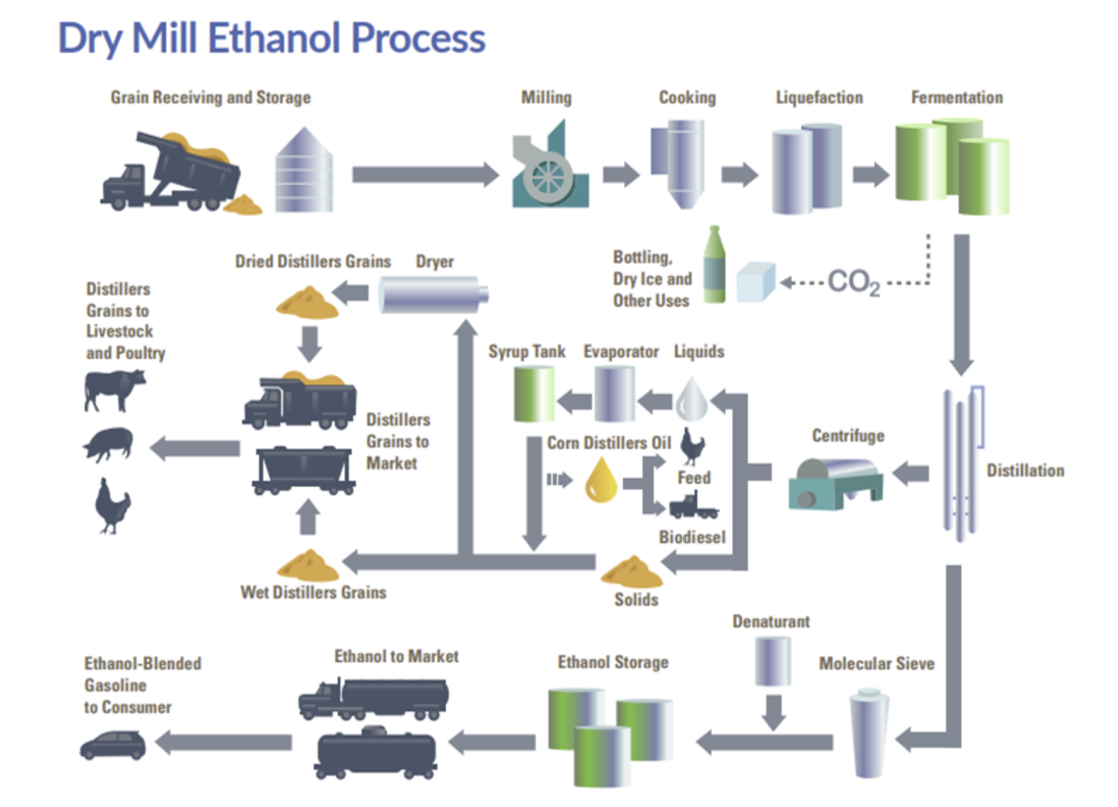

Through mass flow we propose the energy-corn relationship:

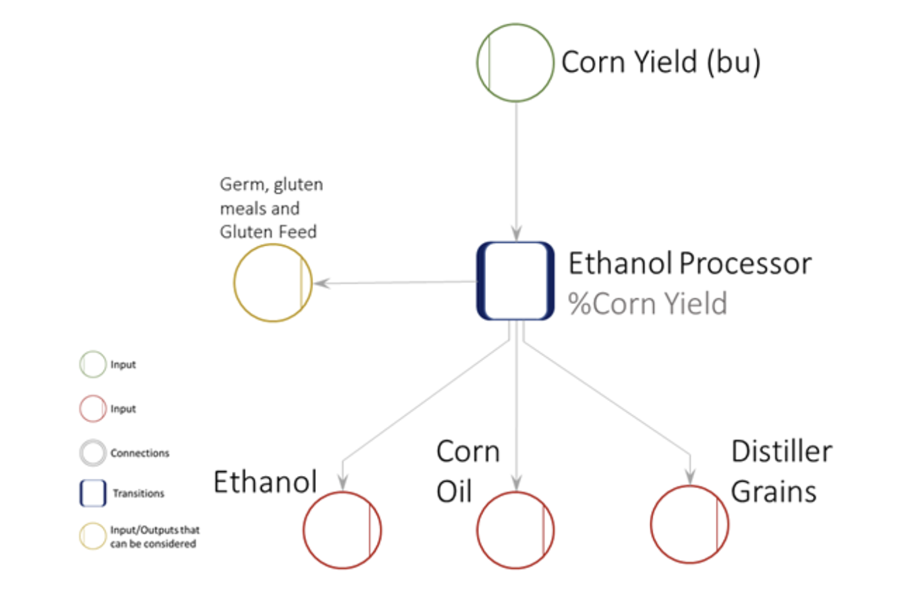

In [2]:
# Set up
import pandas as pd
import numpy as np
import itertools
import os
import warnings
import plotly.express as px
warnings.simplefilter(action='ignore', category=FutureWarning)

parent_dir = os.getcwd()
path = os.path.join('../IFEWs_1997to2019.csv')

# Get Corn Yield (Bu/Ac) for 1997 to 2021 from IFEWs Counties
# Get Harvested Area in Acres
ifews = pd.read_csv(path)

In [3]:
ifews.head(5)

,Unnamed: 0,Year,County,Beef Cattle,Hogs,Milk Cattle,Other Cattle,CAP,CGH,CGY,SH,SAP,SY,State,CN_lb/ac,CN,MN,GN,FN,NS
0,0,1997,Buena Vista,4472.0,296162.000,321.0,0.000000,166100.0,162500.0,146.4,154700.0,155900.0,48.4,IA,65.833687,73.8,24.5,157.1,79.0,20.2
1,1,1998,Buena Vista,4438.5,287105.128,257.5,2743.560000,168300.0,166000.0,154.6,150100.0,150600.0,48.8,IA,65.877839,73.8,24.7,159.9,78.1,16.7
2,2,1999,Buena Vista,4438.5,284370.192,257.5,6864.640000,160000.0,157500.0,165.1,156800.0,157000.0,46.0,IA,63.566293,71.3,25.8,160.1,74.4,11.4
3,3,2000,Buena Vista,4438.5,287957.192,257.5,10593.073333,164000.0,160400.0,135.7,152700.0,153000.0,38.4,IA,68.266223,76.5,27.1,132.1,52.7,24.2
4,4,2001,Buena Vista,4438.5,297866.128,257.5,13928.860000,159000.0,155800.0,144.4,157200.0,158000.0,46.5,IA,58.251779,65.3,28.8,153.8,76.2,16.5


In [33]:
# Get Corn Yield (Bu/Ac) for 1997 to 2021 from IFEWs Counties

corn = ifews[['County',"CGH",'CGY' , 'Year']].copy()

# Calculate Total Bushels per year per County
corn['Total Bushels'] = corn['CGH']*corn['CGY']
#corn['Year'] = pd.to_datetime(corn['Year'], format='%Y')
#corn['Year'] = corn['Year'].dt.year

# Sum all counties (to have Iowa Production) for each year - This can be compared with EIA data
corn_et = corn.groupby(['Year'])['Total Bushels'].sum()

In [35]:
"""
    Use 2009 and up data (due to expressive change in Ethanol Production 
    Energy Independence and Security Act of 2007 statement was to ‘increase the production of clean renewable fuels’  
"""
corn_et = corn_et.drop([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007])
corn_et = corn_et.to_frame()

# Get EIA Ethanol Production in Thousand Barrels
url = 'https://www.eia.gov/state/seds/sep_prod/xls/prod_phy.xlsx'
eia = pd.read_excel(url,'Fuel Ethanol', index_col = 0,  header = 2)
eia = eia.dropna(axis =1)
eia = eia.transpose()
eia = eia[['IA']]
eia = eia.drop([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2020])

In [36]:
# define the objective function
def IFEWs_Ethanol(c, r):
    
    # Base equation IFEWs Ethanol Production 
    """
    Total corn in bushels
    Ethanol in Thousand Barrels
    1 bushel of corn (56lbs) = ~2.8 gals = c
    Total corn that goes to ethanol = 50% = r
    1 gal (US), 0.0238095238 bbl (oil)
    42 gal is 1 barrel
    """
    
    corn_et['Ethanol (Gallons)'] = corn_et['Total Bushels']*c*r #Ethanol in Gallons
    corn_et['Ethanol (Barrels)'] = corn_et['Ethanol (Gallons)']*0.0238095238 #Ethanol in Barrels
    corn_et['Ethanol (Thousands of Barrels)'] = corn_et['Ethanol (Barrels)']/1000
    
    # Combine both dataframes
    comb = pd.concat([corn_et, eia], axis=1)
    #comb.plot()
    comb['e'] = comb['IA'] - comb['Ethanol (Thousands of Barrels)']
    comb['sq_e'] = comb['e']*comb['e']
    
  
    #Function to minimize
    s = comb['sq_e'].sum()
    
    return s


# define the constraints
def constraints(c, r):
    if r < 0.48 or r > 0.65 or c < 2.7 or c > 2.9:
        return False
    return True

# generate all possible combinations of b and c subject to the constraints
combos = itertools.product(
    [r for r in np.arange(0.47, 0.65, 0.01)],
    [c for c in np.arange(2.7, 2.91, 0.01)]
)

combos = [(c, r) for r, c in combos if constraints(c, r)]

# evaluate the objective function for each combination and find the minimum
min_a = float('inf')
best_combo = None
for c, r in combos:
    a = IFEWs_Ethanol(c, r)
    if a < min_a:
        min_a = a
        best_combo = (c, r)

# print the best combination of variables b and c
print(f"Best combination of variables c and r: {best_combo}")

Best combination of variables c and r: (2.71, 0.5800000000000001)


In [ ]:
best_combo[1]

In [44]:
c = best_combo[0]
r = best_combo[1]
corn_et['Ethanol (Gallons)'] = corn_et['Total Bushels']*c*r #Ethanol in Gallons
corn_et['Ethanol (Barrels)'] = corn_et['Ethanol (Gallons)']*0.0238095238 #Ethanol in Barrels
corn_et['Ethanol (Thousands of Barrels)'] = corn_et['Ethanol (Barrels)']/1000
    
# Combine both dataframes
comb = pd.concat([corn_et, eia], axis=1)

In [45]:
comb.head(5)

,Total Bushels,Ethanol (Gallons),Ethanol (Barrels),Ethanol (Thousands of Barrels),IA
2008,2.188642e+09,3.440107e+09,8.190732e+07,81907.321291,56123
2009,2.407287e+09,3.783773e+09,9.008984e+07,90089.839268,74000
2010,2.153213e+09,3.384420e+09,8.058144e+07,80581.436886,84071
2011,2.356460e+09,3.703884e+09,8.818772e+07,88187.718388,89315
2012,1.876819e+09,2.949984e+09,7.023772e+07,70237.718984,86265


In [46]:
comb.drop(columns={'Total Bushels','Ethanol (Gallons)', 'Ethanol (Barrels)'})

,Ethanol (Thousands of Barrels),IA
2008,81907.321291,56123
2009,90089.839268,74000
2010,80581.436886,84071
2011,88187.718388,89315
2012,70237.718984,86265
2013,80095.368215,87238
2014,88596.642741,89188
2015,93930.014808,94058
2016,102559.225060,95983
2017,97766.748662,100558


In [47]:
df = comb[['Ethanol (Thousands of Barrels)', 'IA']]
df = df.reset_index().rename(columns={'index': 'Year'})

# melt the dataframe to long format
df_melt = pd.melt(df, id_vars='Year', var_name='Column', value_name='Value')

# create the plot using plotly express
fig = px.line(df_melt, x='Year', y='Value', color='Column')

# show the plot
fig.show()

In [48]:
corn['Ethanol (Gallons)'] = corn['Total Bushels']*best_combo[0]*best_combo[1]#Ethanol in Gallons
corn['Ethanol (Barrels)'] = corn['Ethanol (Gallons)']*0.024 #Ethanol in Barrels
corn['Ethanol (Thousands of Barrels)'] = corn['Ethanol (Barrels)']/1000

# Sum all counties (to have Iowa Production) for each year - This can be compared with EIA data
corn_et_o = corn.groupby(['Year'])['Ethanol (Thousands of Barrels)'].sum()

"""
Use 2009 and up data (due to expressive change in Ethanol Production 
Energy Independence and Security Act of 2007 statement was to ‘increase the production of clean renewable fuels’  
"""
# Get EIA Ethanol Production in Thousand Barrels
url = 'https://www.eia.gov/state/seds/sep_prod/xls/prod_phy.xlsx'
eia_o = pd.read_excel(url,'Fuel Ethanol', index_col = 0,  header = 2)
eia_o = eia_o.dropna(axis =1)
eia_o = eia_o.transpose()
eia_o = eia_o[['IA']]
eia_o = eia_o.drop([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 2020])

#Combine both dataframes
comb_o = pd.concat([corn_et_o, eia_o], axis= 1)

In [42]:
comb_o

,Ethanol (Thousands of Barrels),IA
1997,61947.508987,10095
1998,66732.856853,10095
1999,66327.191369,10476
2000,65185.403281,10476
2001,62787.053515,10476
2002,72863.575487,10476
2003,70474.628983,14238
2004,84667.662713,20452
2005,81575.878672,26190
2006,77336.726527,35714


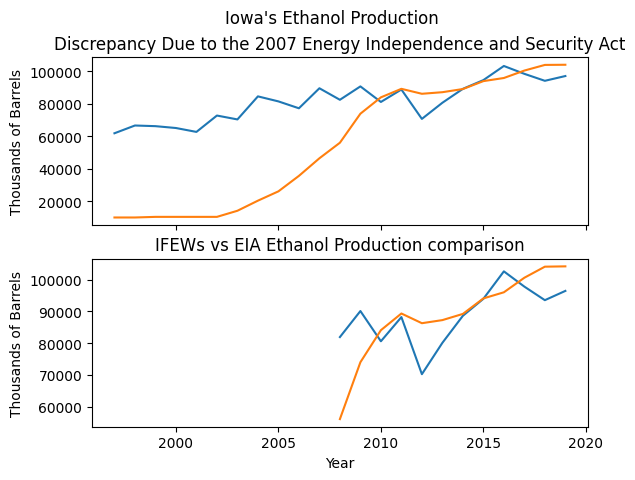

In [52]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle("Iowa's Ethanol Production")
axs[0].plot(comb_o)
axs[0].set_title('Discrepancy Due to the 2007 Energy Independence and Security Act')
axs[1].plot(comb.drop(columns={'Total Bushels','Ethanol (Gallons)', 'Ethanol (Barrels)'}))
axs[1].set_title('IFEWs vs EIA Ethanol Production comparison')
axs[1].set(xlabel='Year')
for ax in axs.flat:
    ax.set(ylabel='Thousands of Barrels')

In [64]:
# from scipy.interpolate import make_interp_spline
# x = comb.index.values    
# y = comb['Ethanol (Thousands of Barrels)'].unique()
# X_Y_Spline = make_interp_spline(x, y)
# # Returns evenly spaced numbers
# # over a specified interval.
# X_ = np.linspace(x.min(), x.max(), 500)
# Y_ = X_Y_Spline(X_)

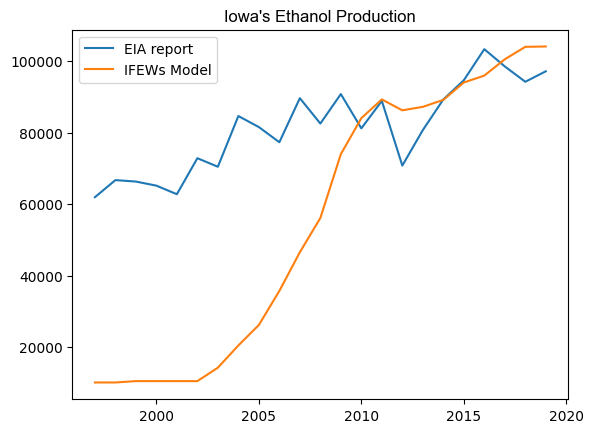

In [80]:
import matplotlib.pyplot as plt
csfont = {'fontname':'Arial'}
hfont = {'fontname':'Helvetica'}

plt.plot(comb_o)
plt.title("Iowa's Ethanol Production", **csfont)
plt.legend(['EIA report', 'IFEWs Model'], loc = 'upper left')